0.84954939932206996


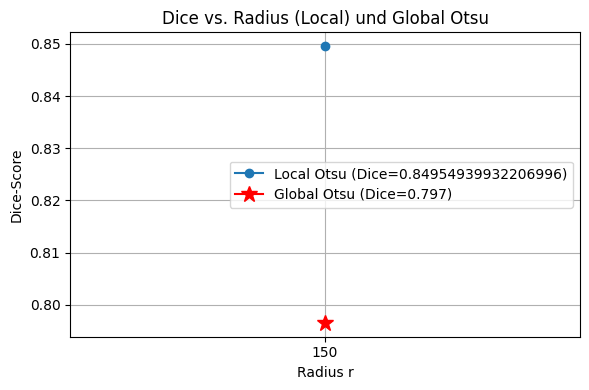

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.filters import threshold_local, threshold_otsu
from src.find_image import find_and_load_image
from src.Otsu_Local import local_otsu_fast

def dice_score(mask, gt):
    inter = np.logical_and(mask, gt).sum()
    return 2 * inter / (mask.sum() + gt.sum())

# 1) Bilder laden
img      = find_and_load_image("dna-49.png",    as_gray=True)
gt       = find_and_load_image("49.png", as_gray=True)
img_u8   = img_as_ubyte(img)
gt_mask  = gt > 0  

# 2) Globaler Otsu einmalig
t_glob   = threshold_otsu(img_u8)
mask_glob= img_u8 > t_glob
dice_glob= dice_score(mask_glob, gt_mask)

# 3) Lokales Otsu für verschiedene Radien
#radii = list(range(300, 1400, 100))
radii = list(range(150, 200, 50))
scores_loc = []
for r in radii:
    t_loc = local_otsu_fast(img_u8, r)
    mask_loc = img_u8 > t_loc
    scores_loc.append(dice_score(mask_loc, gt_mask))

print(f"{max(scores_loc):.17f}")

# 4) Plot beider Kurven
plt.figure(figsize=(6,4))
plt.plot(radii, scores_loc, "-o", label=f"Local Otsu (Dice={max(scores_loc):.17f})")
plt.plot([radii[0], radii[-1]], [dice_glob, dice_glob], "--", color="gray")
# oder als einziger Stern:
plt.plot(radii[len(radii)//2], dice_glob, marker="*", color="red",
         markersize=12, label=f"Global Otsu (Dice={dice_glob:.3f})")

plt.title("Dice vs. Radius (Local) und Global Otsu")
plt.xlabel("Radius r")
plt.ylabel("Dice-Score") 
plt.xticks(radii)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# eval_all_images.py

import os
from pathlib import Path
import numpy as np
from skimage import io, img_as_ubyte
from skimage.filters import threshold_local, threshold_otsu
from itertools import chain
import csv

def dice_score(mask, gt):
    """Dice‐Koeffizient zwischen zwei Bool‐Masken."""
    inter = np.logical_and(mask, gt).sum()
    return 2 * inter / (mask.sum() + gt.sum())

from pathlib import Path

def find_image_pairs(data_root: Path):
    pairs = []
    for dataset_dir in data_root.iterdir():
        img_dir = dataset_dir / "img"
        gt_dir  = dataset_dir / "gt"
        if not img_dir.is_dir() or not gt_dir.is_dir():
            continue

        for img_path in chain(img_dir.glob("*.tif"), img_dir.glob("*.png")):
            if img_path.suffix == ".tif":
                key     = img_path.stem.split("t")[-1] 
                gt_path = gt_dir / f"man_seg{key}.tif"
            elif img_path.suffix == ".png":
                key     = img_path.stem.split("dna-")[-1]
                gt_path = gt_dir / f"{key}.png"
            else: 
                continue 
            print(key,gt_path.name)
            if gt_path.exists():
                    # NUR img_path und gt_path speichern
                    pairs.append((img_path, gt_path))
            else:
                    print(f"⚠ GT fehlt für {img_path.name}")
    return pairs

def eval_best_radius(img_u8, gt_mask, radii):
    best_r, best_score = None, -1.0
    for r in radii:
        t_loc = local_otsu_fast(img_u8, r)
        mask_loc = img_u8 > t_loc
        score = dice_score(mask_loc, gt_mask)
        if score > best_score:
            best_score, best_r = score, r
    return best_r, best_score

def main():
    DATA_DIR = Path("data-git")
    radii    = list(range(0, 1200, 50))

    # Ergebnis‐Dict: { Unterordner: [(Bildname, best_r, best_score), ...], ... }
    results = {}

    for img_path, gt_path in find_image_pairs(DATA_DIR):
        # Bestimme Top‐Level‐Unterordner in Data
        rel = img_path.relative_to(DATA_DIR)
        dataset = rel.parts[0]

        # Lade Original und GT
        img = io.imread(str(img_path), as_gray=True)
        img_u8 = img_as_ubyte(img)
        gt   = io.imread(str(gt_path), as_gray=True)
        gt_mask = gt > 0

        # best radius und score
        r, score = eval_best_radius(img_u8, gt_mask, radii)

        results.setdefault(dataset, []).append((img_path.name, r, score))

    # Ausgabe
    for ds, items in results.items():
        print(f"\n=== Dataset: {ds} ===")
        for name, r, s in items:
            print(f"  {name:20s} → best radius = {r:3d}, Dice = {s:.4f}")

   
    # Angenommen, du hast ein Dict:
     # results = { "N2DH-GOWT1": [("t01.tif", 10), ("t21.tif", 20)], ... }

    with open("best_radius2.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Dataset", "Bild", "BestRadius", "DiceScore"])
        for ds, items in results.items():
            for name, radius, score in items:
                writer.writerow([ds, name, radius, score])
        
    

if __name__ == "__main__":
    main()


75 man_seg75.tif
13 man_seg13.tif
52 man_seg52.tif
79 man_seg79.tif
0 0.png
30 30.png
31 31.png
1 1.png
33 33.png
27 27.png
26 26.png
32 32.png
37 37.png
47 47.png
46 46.png
44 44.png
45 45.png
40 40.png
42 42.png
49 49.png
28 28.png
29 29.png
72 man_seg72.tif
39 man_seg39.tif
01 man_seg01.tif
31 man_seg31.tif
21 man_seg21.tif
52 man_seg52.tif

=== Dataset: N2DL-HeLa ===
  t75.tif              → best radius =  50, Dice = 0.7617
  t13.tif              → best radius = 700, Dice = 0.6624
  t52.tif              → best radius = 200, Dice = 0.6313
  t79.tif              → best radius =  50, Dice = 0.7629

=== Dataset: NIH3T3 ===
  dna-0.png            → best radius = 550, Dice = 0.9074
  dna-30.png           → best radius = 100, Dice = 0.7939
  dna-31.png           → best radius = 100, Dice = 0.8269
  dna-1.png            → best radius = 500, Dice = 0.9000
  dna-33.png           → best radius = 150, Dice = 0.8005
  dna-27.png           → best radius = 100, Dice = 0.8163
  dna-26.png         

Note: you may need to restart the kernel to use updated packages.
      Dataset  BestRadius
0  N2DH-GOWT1      1550.0
1   N2DL-HeLa       300.0
2      NIH3T3       300.0


/var/folders/wd/pl9k9xs93l9bzvhwc5zs9b4m0000gn/T/ipykernel_93695/2450851952.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


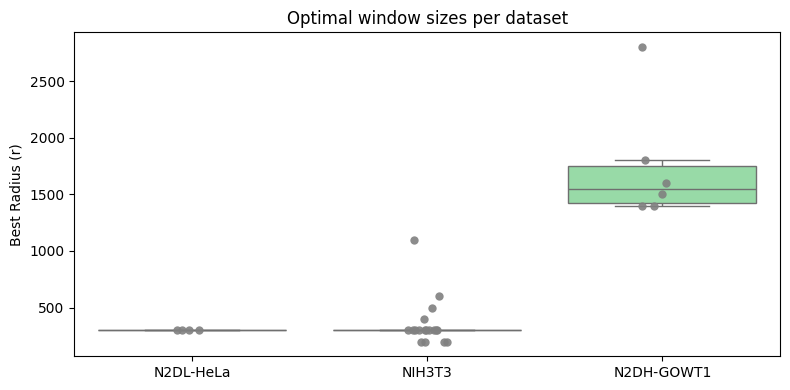

In [2]:
%pip install seaborn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys


# CSV einlesen
df = pd.read_csv("output/best_radius.csv")

df2 = mean_radius = df.groupby("Dataset")["BestRadius"].median().reset_index()
print(df2)
# Größe des Plots
plt.figure(figsize=(8, 4))

# Boxplot mit Seaborn
sns.boxplot(
    x="Dataset",
    y="BestRadius",
    data=df,
    palette="pastel",    # dezente Farbpalette
    showfliers=False      # Ausreißerpunkte zeigen
)

# Optional: einzelne Werte zusätzlich als Jitter-Punkte
sns.stripplot(
    x="Dataset",
    y="BestRadius",
    data=df,
    color="gray",
    alpha=0.9,
    jitter=True,
    size=6
)

# Titel und Achsen beschriften
plt.title("Optimal window sizes per dataset")
plt.ylabel("Best Radius (r)")
plt.xlabel("")

plt.tight_layout()
plt.show()